# Surrogate modeling for HABs

In the scope of the AA 222 final project we are trying to build surrogate models to our objective function (HAB extent) with respect to two design variables (cumulative DRP and springtime DRP). The first step is two provide two surrogate models based on polynomial and radial functions, perform regularization and then pick the best/compare to Ho & Michalak linear model.

In [1]:
#Importing relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.interpolate import RBFInterpolator


### Data Preprocessing

In [2]:
# Importing the dataset from Ho & Michalak (2017) containing objective function values and the corresponding design variables
data=pd.read_excel(r"C:\Users\gotta\OneDrive\Documents\Bureau\X\4A\US\Stanford\Classes\AA 222\Final Project\Data\Dataset.xlsx", engine='openpyxl') 
data=pd.DataFrame(data)
#Remove 
A=np.array(data[['WLE_area_avg']])
CI=np.array(data['WLE_CI_avg'])
X=data[['9year_cum','aprjul']]
X=np.array(X)



### Linear surrogates

In [3]:
#Fit linearly A  to X values
poly = PolynomialFeatures(degree=1)
X_poly = poly.fit_transform(X)
lin_reg = LinearRegression()
lin_reg.fit(X_poly, A)
A_pred = lin_reg.predict(X_poly)
print("Linear Regression Coefficients:", lin_reg.coef_)
print("Linear Regression Intercept:", lin_reg.intercept_)
# Calculate the mean squared error and R^2 score

r2 = r2_score(A, A_pred)

print("R^2 Score:", r2)



Linear Regression Coefficients: [[0.         0.31838624 2.29792759]]
Linear Regression Intercept: [-742.21898475]
R^2 Score: 0.7062183790599444


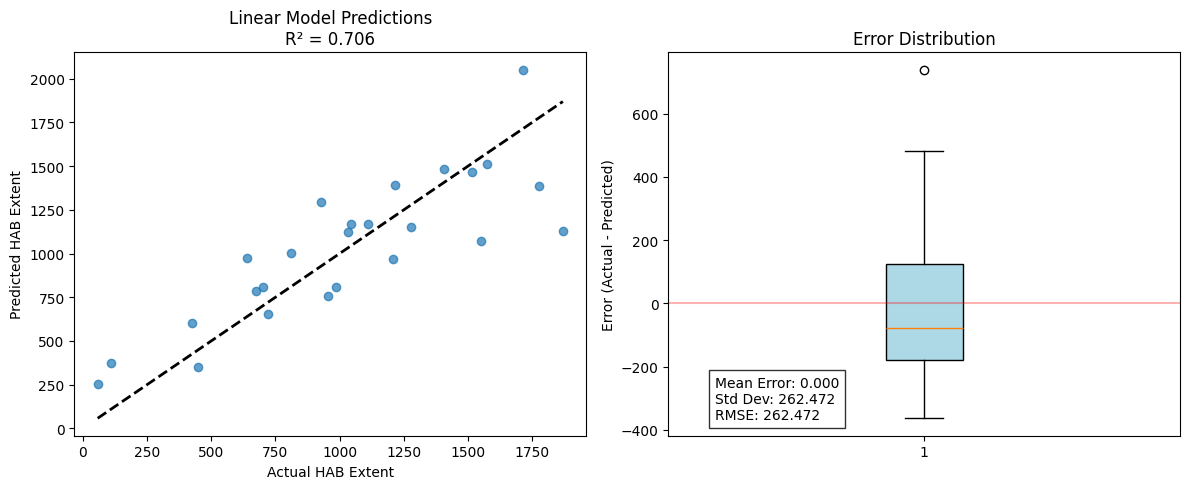

In [4]:
# Calculate the errors for the polynomial model
poly_errors = A - A_pred

# Create a figure with two subplots: one for predictions vs actual and one for the error box plot
plt.figure(figsize=(12, 5))

# First subplot: Predictions vs Actual values
plt.subplot(1, 2, 1)
plt.scatter(A, A_pred, alpha=0.7)
plt.plot([A.min(), A.max()], [A.min(), A.max()], 'k--', lw=2)
plt.xlabel('Actual HAB Extent')
plt.ylabel('Predicted HAB Extent')
plt.title(f'Linear Model Predictions\nR² = {r2:.3f}')

# Second subplot: Box plot of errors
plt.subplot(1, 2, 2)
plt.boxplot(poly_errors, vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.ylabel('Error (Actual - Predicted)')
plt.title('Error Distribution')

# Add text with error statistics
error_mean = np.mean(poly_errors)
error_std = np.std(poly_errors)
rmse = np.sqrt(mean_squared_error(A, A_pred))
plt.figtext(0.60, 0.15, f'Mean Error: {error_mean:.3f}\nStd Dev: {error_std:.3f}\nRMSE: {rmse:.3f}', 
            bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

### Polynomial (degree 2) surrogate

In [5]:

# Set the polynomial degree
degree = 2
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X)

# Fit the polynomial model
model = LinearRegression()
model.fit(X_poly, A)

# Get the coefficients
print("Model coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Make predictions
A_pred = model.predict(X_poly)
r2 = r2_score(A, A_pred)
print("R^2 score:", r2)

Model coefficients: [[ 0.00000000e+00  1.15932573e+00  7.33376654e+00 -9.71725717e-05
  -5.27110541e-04 -5.19438894e-03]]
Intercept: [-2742.27690937]
R^2 score: 0.7797870583907627


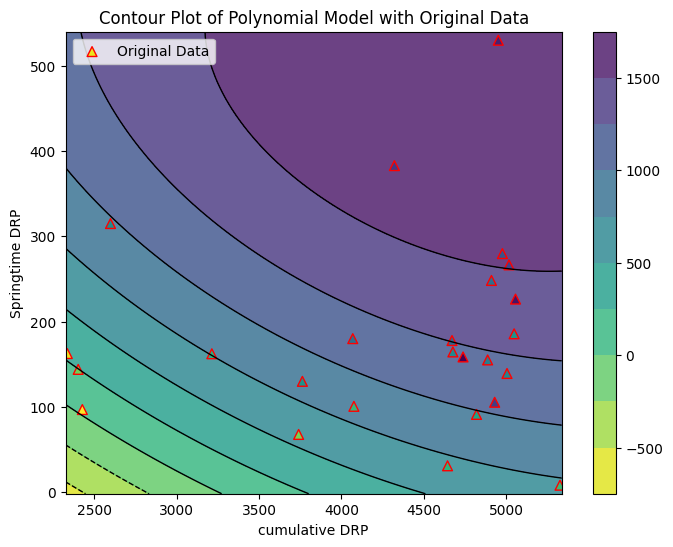

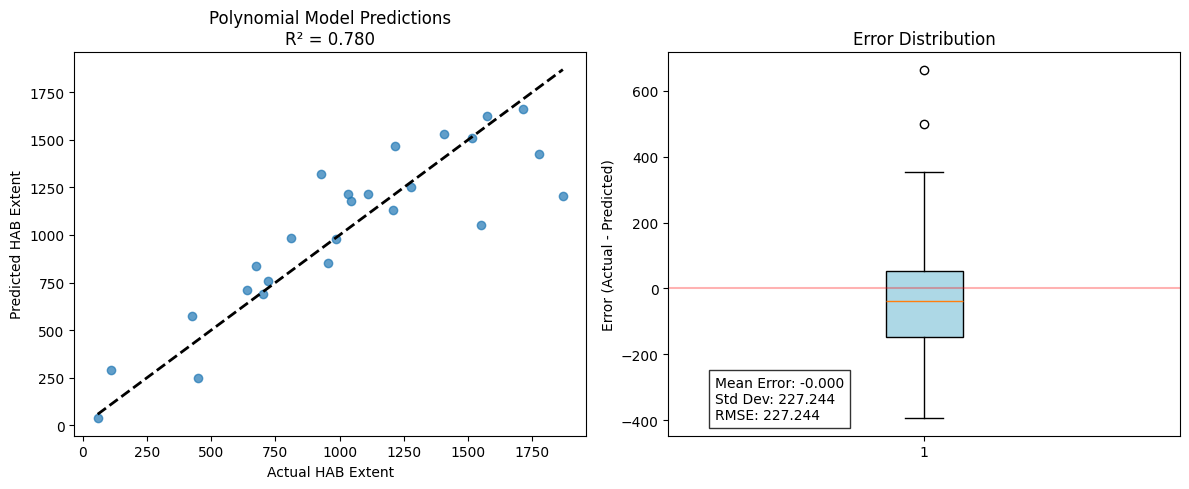

In [6]:

# Create a dense grid for the contour plot
x1_range = np.linspace(min(X[:, 0])-10, max(X[:, 0])+10, 100)
x2_range = np.linspace(min(X[:, 1])-10, max(X[:, 1])+10, 100)
X1, X2 = np.meshgrid(x1_range, x2_range)
X_grid = np.column_stack((X1.ravel(), X2.ravel()))
X_poly_grid = poly.transform(X_grid)

# Predict over the grid to generate the contour levels
y_grid = model.predict(X_poly_grid).reshape(X1.shape)

# Plot the contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(X1, X2, y_grid, 10, cmap='viridis_r', alpha=0.8)
plt.colorbar(contour)
plt.contour(X1, X2, y_grid, 10, colors='black', linewidths=1)

# Scatter the original 32 data points (f_values)
plt.scatter(X[:, 0], X[:, 1], c=A, cmap='viridis_r',s=50, marker='^', edgecolors='red',label='Original Data', alpha=1)

# Labels and title
plt.title("Contour Plot of Polynomial Model with Original Data")
plt.xlabel("cumulative DRP")
plt.ylabel("Springtime DRP")
plt.legend()
plt.show()

# Calculate the errors for the polynomial model
poly_errors = A - A_pred

# Create a figure with two subplots: one for predictions vs actual and one for the error box plot
plt.figure(figsize=(12, 5))

# First subplot: Predictions vs Actual values
plt.subplot(1, 2, 1)
plt.scatter(A, A_pred, alpha=0.7)
plt.plot([A.min(), A.max()], [A.min(), A.max()], 'k--', lw=2)
plt.xlabel('Actual HAB Extent')
plt.ylabel('Predicted HAB Extent')
plt.title(f'Polynomial Model Predictions\nR² = {r2:.3f}')

# Second subplot: Box plot of errors
plt.subplot(1, 2, 2)
plt.boxplot(poly_errors, vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.ylabel('Error (Actual - Predicted)')
plt.title('Error Distribution')

# Add text with error statistics
error_mean = np.mean(poly_errors)
error_std = np.std(poly_errors)
rmse = np.sqrt(mean_squared_error(A, A_pred))
plt.figtext(0.60, 0.15, f'Mean Error: {error_mean:.3f}\nStd Dev: {error_std:.3f}\nRMSE: {rmse:.3f}', 
            bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

In [7]:
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def loocv_poly(X, y, degree=1):
    loo = LeaveOneOut()
    y_true = []
    y_pred = []
    poly = PolynomialFeatures(degree)
    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)
        model = LinearRegression()
        model.fit(X_train_poly, y_train)
        y_pred.append(model.predict(X_test_poly)[0])
        y_true.append(y_test[0])
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2, y_true, y_pred

# Example usage for linear model (degree=1)
rmse_lin, r2_lin, y_true_lin, y_pred_lin = loocv_poly(X, A, degree=1)
print(f"Linear LOOCV: RMSE={rmse_lin:.3f}, R2={r2_lin:.3f}")

# Example usage for polynomial model (degree=2)
rmse_poly, r2_poly, y_true_poly, y_pred_poly = loocv_poly(X, A, degree=2)
print(f"Polynomial LOOCV: RMSE={rmse_poly:.3f}, R2={r2_poly:.3f}")

Linear LOOCV: RMSE=306.020, R2=0.601
Polynomial LOOCV: RMSE=278.488, R2=0.669


### RBF Surrogates (Leave-one out cross validation for multiple kernel, length scales and smoothing parameters)

In [8]:
from scipy.interpolate import Rbf
from sklearn.model_selection import KFold
import numpy as np

# Define a cross-validation function for multiquadric RBF
def cross_val_multiquadric(X_train, y_train, epsilons, gammas, kernels,cv=len(A)):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    best_score = float('inf')
    best_params = None
    for kernel in kernels:
        for epsilon in epsilons:
            for gamma in gammas:
                scores = []
                for train_idx, val_idx in kf.split(X_train):
                    # Split data
                    X_tr, X_val = X_train[train_idx], X_train[val_idx]
                    y_tr, y_val = y_train[train_idx], y_train[val_idx]
                    
                    # Train RBF model
                    rbf = RBFInterpolator(X_tr,y_tr, kernel=kernel, epsilon=epsilon, smoothing=gamma)
                    
                    # Predict on validation set
                    y_pred = rbf(X_val)
                    
                    # Compute validation error
                    score = np.mean((y_pred - y_val)**2)
                    scores.append(score)
                
                # Average cross-validation score
                avg_score = np.mean(scores)
                
                if avg_score < best_score:
                    best_score = avg_score
                    best_params = {'epsilon': epsilon, 'gamma': gamma, 'kernel': kernel}
        
    return best_params, best_score

# Define your hyperparameter search space
kernels = ['multiquadric','gaussian', 'inverse_multiquadric']
epsilons = np.logspace(-6, 3, 100)  # Ranges for epsilon
gammas = np.logspace(-6, 3, 100)    # Ranges for smoothness (gamma)

# Run the hyperparameter search
best_params, best_score = cross_val_multiquadric(X, A, epsilons, gammas, kernels)

print("Best multiquadric parameters:", best_params)
print("Best cross-validated score:", best_score)

Best multiquadric parameters: {'epsilon': np.float64(0.0001232846739442066), 'gamma': np.float64(1.519911082952933e-06), 'kernel': 'gaussian'}
Best cross-validated score: 74559.6378082502


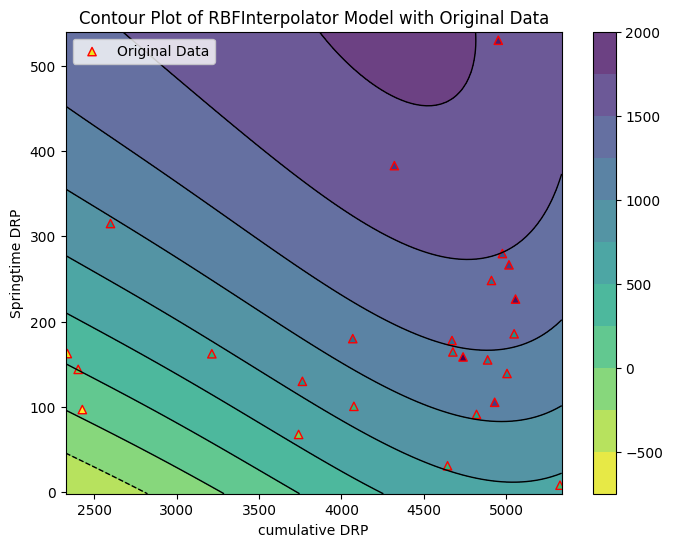

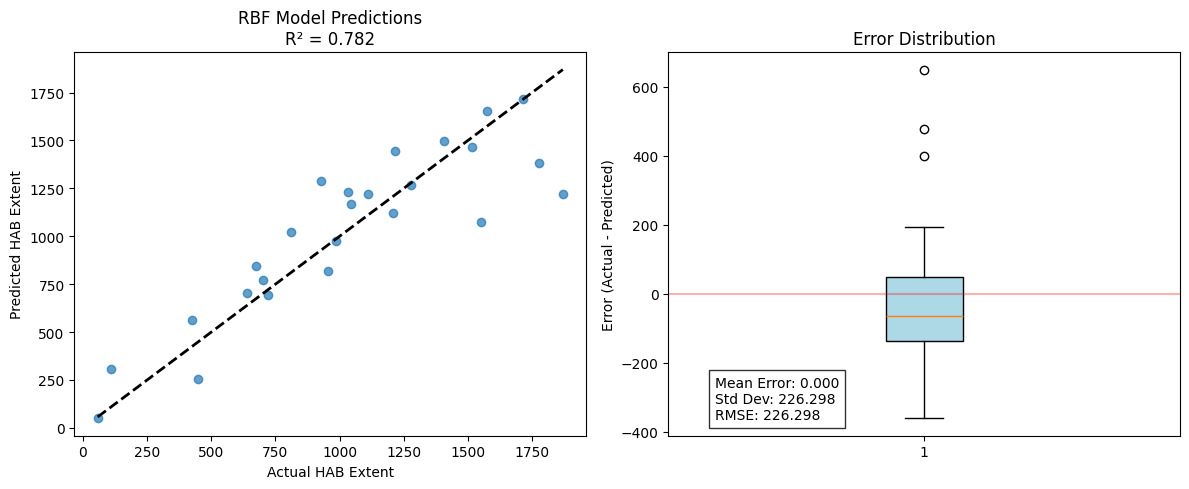

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RBFInterpolator

# Train the RBF model
rbf = RBFInterpolator(X, A, kernel='gaussian',epsilon=0.0001232846739442066,smoothing= 1.519911082952933e-06)
A_pred = rbf(X)
# Create a dense grid for the contour plot
x1_range = np.linspace(min(X[:, 0])-10, max(X[:, 0])+10, 100)
x2_range = np.linspace(min(X[:, 1])-10, max(X[:, 1])+10, 100)
X1, X2 = np.meshgrid(x1_range, x2_range)
X_grid = np.column_stack((X1.ravel(), X2.ravel()))

# Predict over the grid to generate the contour levels
y_grid = rbf(X_grid).reshape(X1.shape)

# Plot the contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(X1, X2, y_grid, 10, cmap='viridis_r', alpha=0.8)
plt.colorbar(contour)
plt.contour(X1, X2, y_grid, 10, colors='black', linewidths=1)

# Scatter the original 32 data points (f_values)
plt.scatter(X[:, 0], X[:, 1], c=A, cmap='viridis_r', marker='^', edgecolors='red',label='Original Data', alpha=1)

# Labels and title
plt.title("Contour Plot of RBFInterpolator Model with Original Data")
plt.xlabel("cumulative DRP")
plt.ylabel("Springtime DRP")
plt.legend()
plt.show()


poly_errors = A - A_pred
r2 = r2_score(A, A_pred)
# Create a figure with two subplots: one for predictions vs actual and one for the error box plot
plt.figure(figsize=(12, 5))

# First subplot: Predictions vs Actual values
plt.subplot(1, 2, 1)
plt.scatter(A, A_pred, alpha=0.7)
plt.plot([A.min(), A.max()], [A.min(), A.max()], 'k--', lw=2)
plt.xlabel('Actual HAB Extent')
plt.ylabel('Predicted HAB Extent')
plt.title(f'RBF Model Predictions\nR² = {r2:.3f}')

# Second subplot: Box plot of errors
plt.subplot(1, 2, 2)
plt.boxplot(poly_errors, vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.ylabel('Error (Actual - Predicted)')
plt.title('Error Distribution')

# Add text with error statistics
error_mean = np.mean(poly_errors)
error_std = np.std(poly_errors)
rmse = np.sqrt(mean_squared_error(A, A_pred))
plt.figtext(0.60, 0.15, f'Mean Error: {error_mean:.3f}\nStd Dev: {error_std:.3f}\nRMSE: {rmse:.3f}', 
            bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# CI_avg Surrogates

### Linear surrogate

In [10]:
#Fit linearly CI_avg  to X values
poly = PolynomialFeatures(degree=1)
X_poly = poly.fit_transform(X)
lin_reg = LinearRegression()
lin_reg.fit(X_poly, CI)
CI_pred = lin_reg.predict(X_poly)
print("Linear Regression Coefficients:", lin_reg.coef_)
print("Linear Regression Intercept:", lin_reg.intercept_)
# Calculate the mean squared error and R^2 score

r2 = r2_score(CI, CI_pred)

print("R^2 Score:", r2)


Linear Regression Coefficients: [0.         0.00348731 0.04818059]
Linear Regression Intercept: -15.344444752266575
R^2 Score: 0.7648115059389179


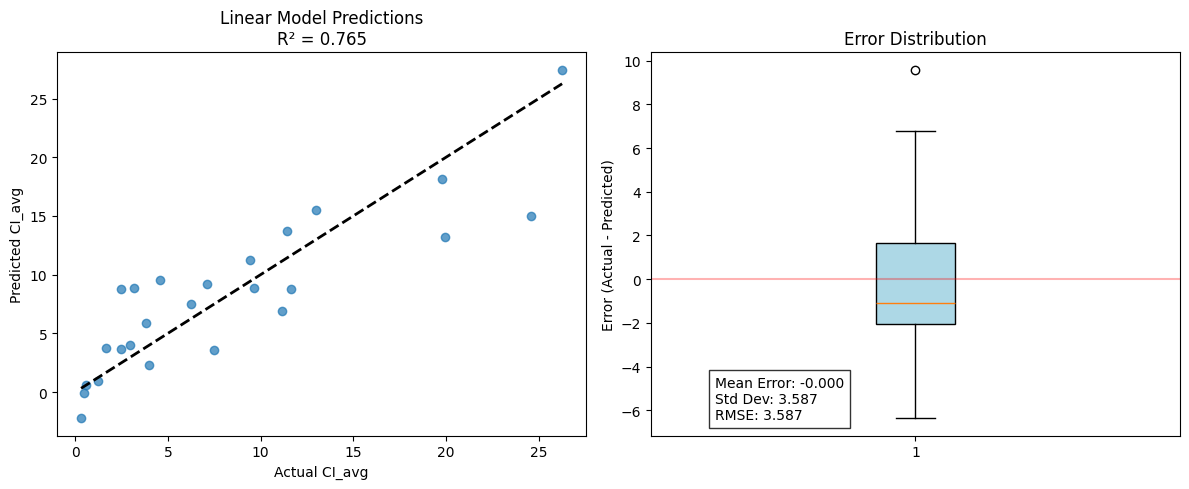

In [11]:
# Calculate the errors for the linear model
poly_errors = CI - CI_pred

# Create a figure with two subplots: one for predictions vs actual and one for the error box plot
plt.figure(figsize=(12, 5))

# First subplot: Predictions vs Actual values
plt.subplot(1, 2, 1)
plt.scatter(CI, CI_pred, alpha=0.7)
plt.plot([CI.min(), CI.max()], [CI.min(), CI.max()], 'k--', lw=2)
plt.xlabel('Actual CI_avg')
plt.ylabel('Predicted CI_avg')
plt.title(f'Linear Model Predictions\nR² = {r2:.3f}')

# Second subplot: Box plot of errors
plt.subplot(1, 2, 2)
plt.boxplot(poly_errors, vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.ylabel('Error (Actual - Predicted)')
plt.title('Error Distribution')

# Add text with error statistics
error_mean = np.mean(poly_errors)
error_std = np.std(poly_errors)
rmse = np.sqrt(mean_squared_error(CI, CI_pred))
plt.figtext(0.60, 0.15, f'Mean Error: {error_mean:.3f}\nStd Dev: {error_std:.3f}\nRMSE: {rmse:.3f}', 
            bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

### Polynomial (degree 2) surrogate

In [12]:
# Set the polynomial degree
degree = 2
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X)

# Fit the polynomial model
model = LinearRegression()
model.fit(X_poly, CI)

# Get the coefficients
print("Model coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Make predictions
CI_pred = model.predict(X_poly)
r2 = r2_score(CI, CI_pred)
print("R^2 score:", r2)

Model coefficients: [ 0.00000000e+00 -7.66300341e-03  4.43048133e-02  1.48037048e-06
 -5.26642163e-07  1.20878145e-05]
Intercept: 4.560071263812404
R^2 score: 0.7842490536903544


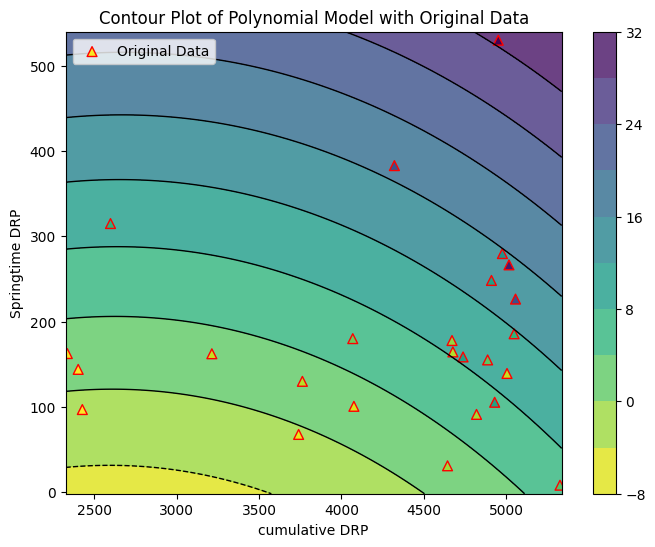

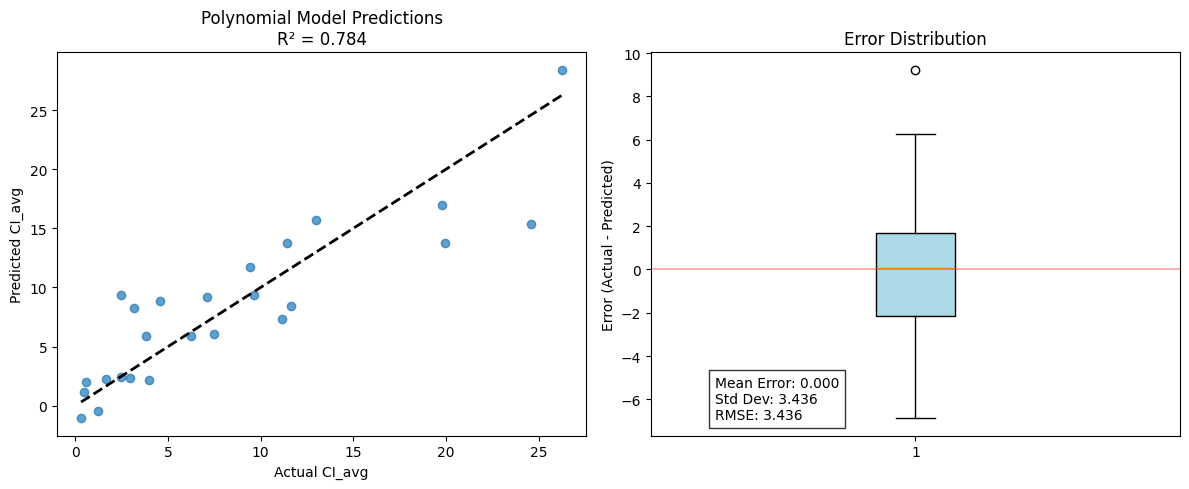

In [13]:
# Create a dense grid for the contour plot
x1_range = np.linspace(min(X[:, 0])-10, max(X[:, 0])+10, 100)
x2_range = np.linspace(min(X[:, 1])-10, max(X[:, 1])+10, 100)
X1, X2 = np.meshgrid(x1_range, x2_range)
X_grid = np.column_stack((X1.ravel(), X2.ravel()))
X_poly_grid = poly.transform(X_grid)

# Predict over the grid to generate the contour levels
y_grid = model.predict(X_poly_grid).reshape(X1.shape)

# Plot the contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(X1, X2, y_grid, 10, cmap='viridis_r', alpha=0.8)
plt.colorbar(contour)
plt.contour(X1, X2, y_grid, 10, colors='black', linewidths=1)

# Scatter the original 32 data points (f_values)
plt.scatter(X[:, 0], X[:, 1], c=CI, cmap='viridis_r',s=50, marker='^', edgecolors='red',label='Original Data', alpha=1)

# Labels and title
plt.title("Contour Plot of Polynomial Model with Original Data")
plt.xlabel("cumulative DRP")
plt.ylabel("Springtime DRP")
plt.legend()
plt.show()

# Calculate the errors for the polynomial model
poly_errors = CI - CI_pred

# Create a figure with two subplots: one for predictions vs actual and one for the error box plot
plt.figure(figsize=(12, 5))

# First subplot: Predictions vs Actual values
plt.subplot(1, 2, 1)
plt.scatter(CI, CI_pred, alpha=0.7)
plt.plot([CI.min(), CI.max()], [CI.min(), CI.max()], 'k--', lw=2)
plt.xlabel('Actual CI_avg')
plt.ylabel('Predicted CI_avg')
plt.title(f'Polynomial Model Predictions\nR² = {r2:.3f}')

# Second subplot: Box plot of errors
plt.subplot(1, 2, 2)
plt.boxplot(poly_errors, vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.ylabel('Error (Actual - Predicted)')
plt.title('Error Distribution')

# Add text with error statistics
error_mean = np.mean(poly_errors)
error_std = np.std(poly_errors)
rmse = np.sqrt(mean_squared_error(CI, CI_pred))
plt.figtext(0.60, 0.15, f'Mean Error: {error_mean:.3f}\nStd Dev: {error_std:.3f}\nRMSE: {rmse:.3f}', 
            bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

### RBF surrogates (for LOOCV with multiple choises of kernels, length scales and smoothing parameters)

In [14]:
from scipy.interpolate import Rbf
from sklearn.model_selection import KFold
import numpy as np

# Define a cross-validation function for multiquadric RBF
def cross_val_multiquadric(X_train, y_train, epsilons, gammas, kernels,cv=len(CI)):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    best_score = float('inf')
    best_params = None
    for kernel in kernels:
        for epsilon in epsilons:
            for gamma in gammas:
                scores = []
                for train_idx, val_idx in kf.split(X_train):
                    # Split data
                    X_tr, X_val = X_train[train_idx], X_train[val_idx]
                    y_tr, y_val = y_train[train_idx], y_train[val_idx]
                    
                    # Train RBF model
                    rbf = RBFInterpolator(X_tr,y_tr, kernel=kernel, epsilon=epsilon, smoothing=gamma)
                    
                    # Predict on validation set
                    y_pred = rbf(X_val)
                    
                    # Compute validation error
                    score = np.mean((y_pred - y_val)**2)
                    scores.append(score)
                
                # Average cross-validation score
                avg_score = np.mean(scores)
                
                if avg_score < best_score:
                    best_score = avg_score
                    best_params = {'epsilon': epsilon, 'gamma': gamma, 'kernel': kernel}
        
    return best_params, best_score

# Define your hyperparameter search space
kernels = ['multiquadric','gaussian', 'inverse_multiquadric']
epsilons = np.logspace(-6, 3, 100)  # Ranges for epsilon
gammas = np.logspace(-6, 3, 100)    # Ranges for smoothness (gamma)

# Run the hyperparameter search
best_params, best_score = cross_val_multiquadric(X, CI, epsilons, gammas, kernels)

print("Best multiquadric parameters:", best_params)
print("Best cross-validated score:", best_score)

Best multiquadric parameters: {'epsilon': np.float64(6.579332246575683e-05), 'gamma': np.float64(6.579332246575683e-05), 'kernel': 'multiquadric'}
Best cross-validated score: 14.734971715820448


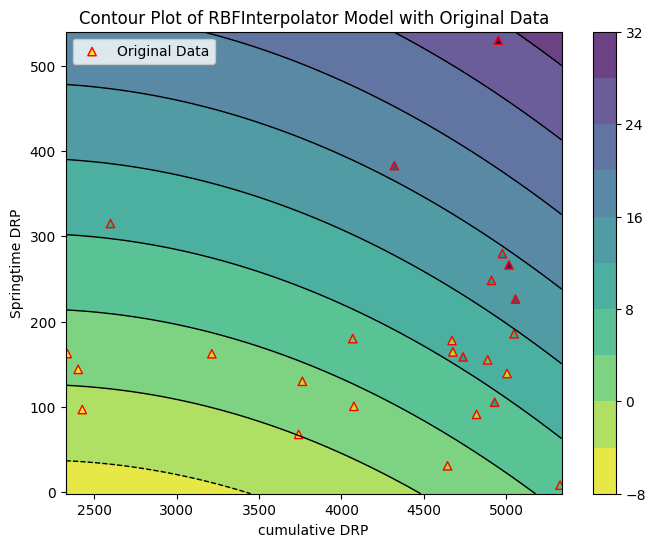

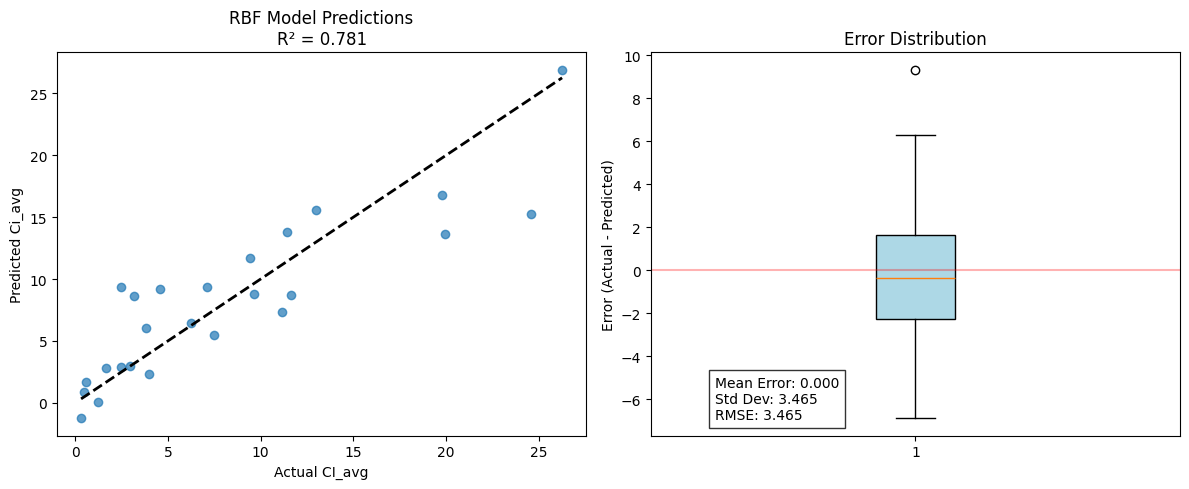

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RBFInterpolator

# Train the RBF model
rbf = RBFInterpolator(X, CI, kernel='multiquadric',epsilon=6.579332246575683e-05,smoothing= 6.579332246575683e-05)
CI_pred = rbf(X)
# Create a dense grid for the contour plot
x1_range = np.linspace(min(X[:, 0])-10, max(X[:, 0])+10, 100)
x2_range = np.linspace(min(X[:, 1])-10, max(X[:, 1])+10, 100)
X1, X2 = np.meshgrid(x1_range, x2_range)
X_grid = np.column_stack((X1.ravel(), X2.ravel()))

# Predict over the grid to generate the contour levels
y_grid = rbf(X_grid).reshape(X1.shape)

# Plot the contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(X1, X2, y_grid, 10, cmap='viridis_r', alpha=0.8)
plt.colorbar(contour)
plt.contour(X1, X2, y_grid, 10, colors='black', linewidths=1)

# Scatter the original 32 data points (f_values)
plt.scatter(X[:, 0], X[:, 1], c=CI, cmap='viridis_r', marker='^', edgecolors='red',label='Original Data', alpha=1)

# Labels and title
plt.title("Contour Plot of RBFInterpolator Model with Original Data")
plt.xlabel("cumulative DRP")
plt.ylabel("Springtime DRP")
plt.legend()
plt.show()


poly_errors = CI - CI_pred
r2 = r2_score(CI, CI_pred)
# Create a figure with two subplots: one for predictions vs actual and one for the error box plot
plt.figure(figsize=(12, 5))

# First subplot: Predictions vs Actual values
plt.subplot(1, 2, 1)
plt.scatter(CI, CI_pred, alpha=0.7)
plt.plot([CI.min(), CI.max()], [CI.min(), CI.max()], 'k--', lw=2)
plt.xlabel('Actual CI_avg')
plt.ylabel('Predicted Ci_avg')
plt.title(f'RBF Model Predictions\nR² = {r2:.3f}')

# Second subplot: Box plot of errors
plt.subplot(1, 2, 2)
plt.boxplot(poly_errors, vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.ylabel('Error (Actual - Predicted)')
plt.title('Error Distribution')

# Add text with error statistics
error_mean = np.mean(poly_errors)
error_std = np.std(poly_errors)
rmse = np.sqrt(mean_squared_error(CI, CI_pred))
plt.figtext(0.60, 0.15, f'Mean Error: {error_mean:.3f}\nStd Dev: {error_std:.3f}\nRMSE: {rmse:.3f}', 
            bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()